### Preprocessing

We will train with full data using multiple workers in cloud. To preprocess 8000 intances, it takes about 2~3 hours with 10 workers.

In [9]:
from datalab_solutions.inception import *
from datalab.mlalpha import *
import os

bucket = 'gs://' + datalab_project_id() + '-coast'
preprocessed_dir = bucket + '/preprocessed'
staging_dir = bucket + '/staging'
model_dir = bucket + '/model'

In [1]:
train_set = BigQueryDataSet('SELECT image_url, label FROM coast.train')
cloud_preprocess(train_set, preprocessed_dir, pipeline_option={'num_workers': 10})

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning:

Using fallback coder for typehint: Any.



Job "preprocess-inception-170215-190627" submitted. Click here to track preprocessing job.

### Training

If it is the first time training for a while, warm-up takes about 5~10 minutes so the whole training takes about 20 minutes. On subsequent trainings, warm up time is about 1 minute.

In [2]:
cloud_train(preprocessed_dir, 64, 2000, model_dir, CloudTrainingConfig('us-central1', 'BASIC'))

Job "inception_train_170215_222255" submitted. Click here to view cloud log.

Check your job status.

In [5]:
Job('inception_train_170215_222255').describe()

createTime: '2017-02-15T22:22:56Z'
jobId: inception_train_170215_222255
startTime: '2017-02-15T22:30:35Z'
state: RUNNING
trainingInput:
  args:
  - --checkpoint
  - gs://cloud-ml-data/img/flower_photos/inception_v3_2016_08_28.ckpt
  - --input_dir
  - gs://bradley-playground-coast/preprocessed
  - --max_steps
  - '2000'
  - --output_path
  - gs://bradley-playground-coast/model
  - --batch_size
  - '64'
  packageUris:
  - gs://cloud-datalab/deploy/tf/tensorflow-1.0.0rc1-cp27-none-linux_x86_64.whl
  - gs://bradley-playground-coast/model/staging/inception.tar.gz
  pythonModule: datalab_solutions.inception.task
  region: us-central1
trainingOutput: {}



### Evaluation

First, we can check the TF summary events from training.

In [15]:
summary = Summary(model_dir)
summary.list_events()

{u'accuracy': {u'gs://bradley-playground-coast/model/eval_set',
  u'gs://bradley-playground-coast/model/train_set'},
 u'batch/fraction_of_448_full': {u'gs://bradley-playground-coast/model/eval_set',
  u'gs://bradley-playground-coast/model/train_set'},
 u'global_step/sec': {u'gs://bradley-playground-coast/model/train'},
 u'input_producer/fraction_of_32_full': {u'gs://bradley-playground-coast/model/eval_set',
  u'gs://bradley-playground-coast/model/train_set'},
 u'loss': {u'gs://bradley-playground-coast/model/eval_set',
  u'gs://bradley-playground-coast/model/train_set'}}

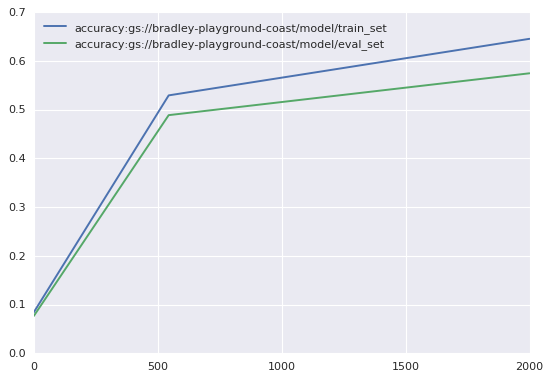

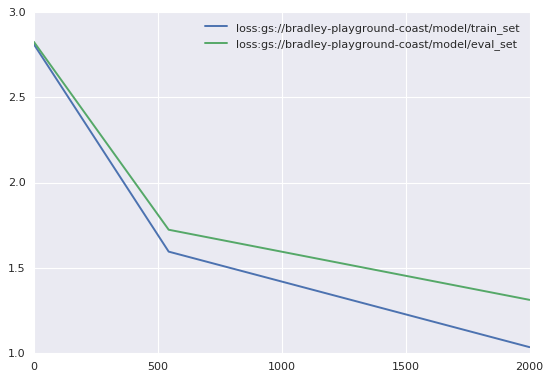

In [16]:
summary.plot('accuracy')
summary.plot('loss')

### Model Deployment

Deploy the model so we can do online prediction.

In [15]:
Models().create('coast1')
ModelVersions('coast1').deploy('v3', model_dir)

Waiting for operation "projects/bradley-playground/operations/create_coast1_v3-1487205696587"
Done.


In [16]:
ModelVersions('coast1').describe('v3')

createTime: '2017-02-16T00:41:36Z'
deploymentUri: gs://bradley-playground-coast/model/model
isDefault: true
name: projects/bradley-playground/models/coast1/versions/v3



### Online Prediction

In [ ]:
# gs://tamucc_coastline/esi_images/IMG_2849_SecDE_Spr12.jpg,3B
# gs://tamucc_coastline/esi_images/IMG_0047_SecBC_Spr12.jpg,10A
# gs://tamucc_coastline/esi_images/IMG_0617_SecBC_Spr12.jpg,7
# gs://tamucc_coastline/esi_images/IMG_2034_SecEGH_Sum12_Pt2.jpg,10A
images = [
  'gs://tamucc_coastline/esi_images/IMG_2849_SecDE_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_0047_SecBC_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_0617_SecBC_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_2034_SecEGH_Sum12_Pt2.jpg'
]
cloud_predict('coast1.v3', images)

Batch prediction.

In [12]:
eval_set = BigQueryDataSet('select * from coast.eval')
cloud_batch_predict(eval_set, model_dir, staging_dir, output_bq_table='coast.eval_results_full',
                    pipeline_option={'num_workers': 10})

Job "batch-predict-inception-170215-233723" submitted. Click here to track batch prediction job.

Check evaluation results. It seems our model doesn't perform well on infrequent labels.

In [11]:
%%sql --module accuracy
SELECT 
  (100.0 * correct.count) / total.count as accuracy, 
  correct.count as correct,
  total.count as count, 
  'label:' + correct.t as feature
FROM
(SELECT
  target as t, count(*) as count
FROM
  coast.eval_results_full
WHERE
  predicted == target
GROUP BY
  t) correct
JOIN
(SELECT
  target as t, count(*) as count
FROM
  coast.eval_results_full
GROUP BY
  t) total ON correct.t = total.t

In [12]:
%%bigquery execute -q accuracy

accuracy,correct,count,feature
2.22222222222,2,90,label:1
3.44827586207,3,87,label:5
72.7272727273,88,121,label:3A
15.625,5,32,label:3B
28.4615384615,37,130,label:6A
43.2432432432,32,74,label:8A
55.8252427184,115,206,label:8C
79.1532690247,1477,1866,label:10A
7.00808625337,26,371,label:10D


We can further improve on the following:

1. Our train/eval set don't completely match in label distribution (intentional). We can randomly split train/eval again.
2. 2000 steps in training is not enough. From loss and accuracy curve, it has not converged yet. Perhaps 5000 steps?
3. Need more training data on infrequent labels.